# Objective 1: DICOM loading and visualization

## Import libraries

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt,  animation
import scipy
import cv2
from IPython.display import Image


import constants as ct
import utils
from utils import load_ct, load_ct_series, load_segmentation, load_pixelarray_positions, reslice_segmentations

## 1. Load Headers 

First, we examine the headers from one slice: 

In [4]:
slice = ct.REFERENCE_IMAGE + 'dicom-00011.dcm'
ref_img = load_ct(slice)
print(" Acquisition Number", ref_img.AcquisitionNumber)
print(" Instance Number", ref_img.InstanceNumber)
print(" Slice Location", ref_img.SliceLocation)
print(" Slice Thickness", ref_img.SliceThickness)
print(" Pixel Spacing", ref_img.PixelSpacing)
print(" Image Position Patient", ref_img.ImagePositionPatient)

sliceThickness = ref_img.SliceThickness
pixelSpacing = ref_img.PixelSpacing

 Acquisition Number 3
 Instance Number 11
 Slice Location -37.000000
 Slice Thickness 5.000000
 Pixel Spacing [0.703125, 0.703125]
 Image Position Patient [-189.351562, -189.140625, -37.000000]


Then, the segmentation is loaded and the headers inspected:

In [5]:
slice_liver = ct.LIVER_SEGMENTATION 
liver = load_ct(slice_liver)

print("Liver: ", liver.PerFrameFunctionalGroupsSequence[0].PlanePositionSequence[0])
print("Liver: ",liver.PerFrameFunctionalGroupsSequence[0].SegmentIdentificationSequence[0])

Liver:  (0020,0032) Image Position (Patient)            DS: [-189.351562, -189.140625, -172.000000]
Liver:  (0062,000B) Referenced Segment Number           US: 1


In [6]:
slice_tumor = ct.TUMOR_SEGMENTATION 
tumor = load_ct(slice_tumor)

print("Tumor:",tumor.PerFrameFunctionalGroupsSequence[0].PlanePositionSequence[0])
print("Tumor:",tumor.PerFrameFunctionalGroupsSequence[0].SegmentIdentificationSequence[0])

Tumor: (0020,0032) Image Position (Patient)            DS: [-189.351562, -189.140625, -97.000000]
Tumor: (0062,000B) Referenced Segment Number           US: 1


## 2. Load all the slices

All the slices from the reference image are loaded and the volume is created. It is also checked whether all the slices come from the same acquisition.

In [13]:
ct_volume, slice_positions, number, slice_locations = load_ct_series(ct.REFERENCE_IMAGE)
print(f"Check if all the slices contain only a single acquisition: {np.unique(number)}")   

The reference CT volume has a shape of: (54, 512, 512)
Check if all the slices contain only a single acquisition: [3]


## 3. Load and reslice segmentations

First, we load the segmentations:

In [ ]:
liver_segmented =load_segmentation(slice_liver)
liver_seg = liver_segmented.pixel_array
print("LIVER ROI SHAPE: ", liver_seg.shape)

tumor_segmented = load_segmentation(slice_tumor)
tumor_seg = tumor_segmented.pixel_array
print("TUMOR ROI SHAPE: ", tumor_seg.shape)

LIVER ROI SHAPE:  (32, 512, 512)
TUMOR ROI SHAPE:  (11, 512, 512)


As we can see, the masks have different shapes

For each mask, we can inspect the label ( 'Liver' or 'Tumor') and the voxels labeled number: 

In [ ]:
for item in liver_segmented.SegmentSequence:
    print(item.SegmentLabel, item.SegmentNumber)

for item in tumor_segmented.SegmentSequence:
    print(item.SegmentLabel, item.SegmentNumber)

Liver 1
Tumor 1


Then, we reslice the masks to have the same shape as the volume image, and assign new labels:

In [ ]:
liver_array, liver_pos = load_pixelarray_positions(liver_segmented)
liver_volume = reslice_segmentations(ct_volume.shape,liver_pos,slice_positions, liver_array, label_value=1)
print(liver_volume.shape)

tumor_array, tumor_pos = load_pixelarray_positions(tumor_segmented)
tumor_volume = reslice_segmentations(ct_volume.shape,tumor_pos,slice_positions, tumor_array, label_value=2)
print(tumor_volume.shape)

(54, 512, 512)
(54, 512, 512)


In [ ]:
print(np.unique(liver_volume))
print(np.unique(tumor_volume))

[0 1]
[0 2]


Then, we join both masks:

In [ ]:
final_segmentation = liver_volume.copy()
final_segmentation[tumor_volume > 0] = tumor_volume[tumor_volume > 0]
print(np.unique(final_segmentation))

[0 1 2]


Axial view of the masks:

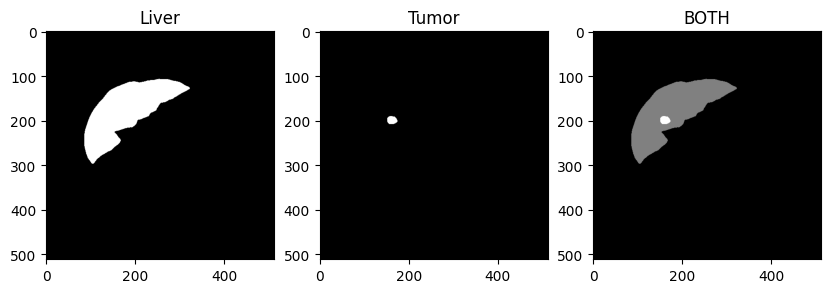

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(liver_volume[33,:,:], cmap='gray')
ax[0].set_title('Liver')
ax[1].imshow(tumor_volume[33,:,:], cmap='gray')
ax[1].set_title('Tumor')
ax[2].imshow(final_segmentation[33,:,:], cmap='gray')
ax[2].set_title('BOTH')
plt.show()

For the coronal and sagittal view, we need the slice resolution:

In [ ]:
pixel_len = np.array([float(pixelSpacing[0]), float(pixelSpacing[1]), float(sliceThickness)])
print(pixel_len)
print(pixel_len[2]/pixel_len[0])
print(pixel_len[2]/pixel_len[1])

[0.703125 0.703125 5.      ]
7.111111111111111
7.111111111111111


Coronal View:

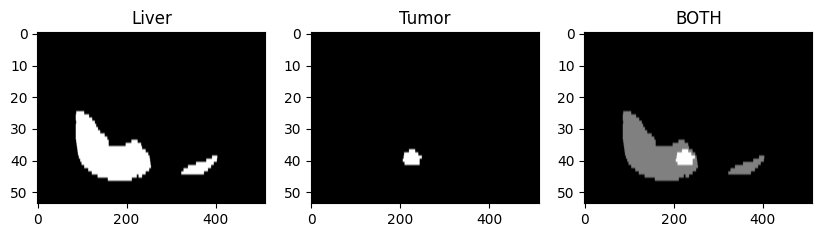

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(liver_volume[:,224,:], cmap='gray', aspect = pixel_len[2]/pixel_len[0] )
ax[0].set_title('Liver')
ax[1].imshow(tumor_volume[:,224,:], cmap='gray',  aspect = pixel_len[2]/pixel_len[0])
ax[1].set_title('Tumor')
ax[2].imshow(final_segmentation[:,224,:], cmap='gray',  aspect = pixel_len[2]/pixel_len[0])
ax[2].set_title('BOTH')
plt.show()

Sagittal view:

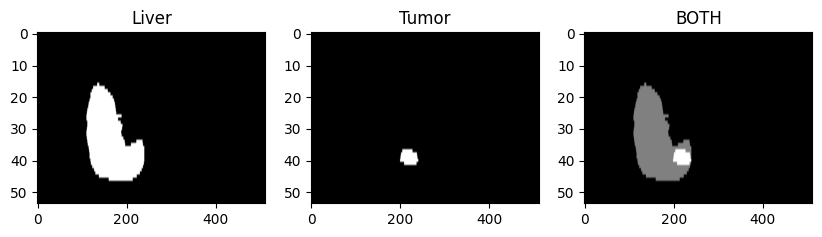

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(liver_volume[:,:,224], cmap='gray', aspect = pixel_len[2]/pixel_len[1] )
ax[0].set_title('Liver')
ax[1].imshow(tumor_volume[:,:,224], cmap='gray',  aspect = pixel_len[2]/pixel_len[1])
ax[1].set_title('Tumor')
ax[2].imshow(final_segmentation[:,:,224], cmap='gray',  aspect = pixel_len[2]/pixel_len[1])
ax[2].set_title('BOTH')
plt.show()

# 4.Rotating MIP

List of functions used to visualize the median axial, coronal and sagittal planes. Also, to compute the MIP.

In [ ]:
def median_axial_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median axial plane of the CT image provided. """
    return img_dcm[img_dcm.shape[0]//2, :, :]

def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, :, img_dcm.shape[2]//2]

def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median coronal plane of the CT image provided. """
    return img_dcm[:, img_dcm.shape[1]//2, :]

def MIP_axial_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=0)

def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)


def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)


The volume and masks are rotated for better visualization:

In [ ]:
ct_volume = np.flip(ct_volume, axis=0) 
final_segmentation =  np.flip(final_segmentation, axis=0) 

Compute the median planes for each axis:

In [ ]:
slice_axial = median_axial_plane(ct_volume)
slice_sagittal = median_sagittal_plane(ct_volume)
slice_coronal = median_coronal_plane(ct_volume)

We compute the minimum and maximum of the images we want to visualize:

In [ ]:
cm = matplotlib.colormaps['bone']

img_min_sag = np.min(slice_sagittal)
img_max_sag = np.max(slice_sagittal)
img_min_cor = np.min(slice_coronal)
img_max_cor = np.max(slice_coronal)
img_min_ax = np.min(slice_axial)
img_max_ax = np.max(slice_axial)

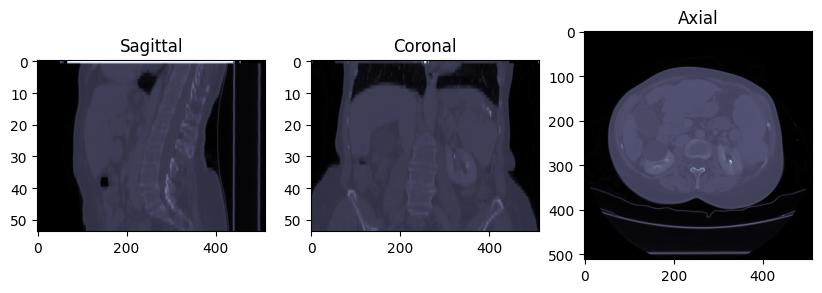

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(slice_sagittal, cmap=cm,vmin = img_min_sag, vmax = img_max_sag, aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Sagittal')
ax[1].imshow(slice_coronal, cmap=cm, vmin = img_min_cor, vmax = img_max_cor,aspect= (pixel_len[2]/pixel_len[1]))
ax[1].set_title('Coronal')
ax[2].imshow(slice_axial, cmap=cm,vmin = img_min_ax, vmax = img_max_ax)
ax[2].set_title('Axial')
plt.show()

As we can see, some structure at the sagittal and axial slices is visible. I will remove this to have a better visualization of the organs:

Umbral de Otsu: -478


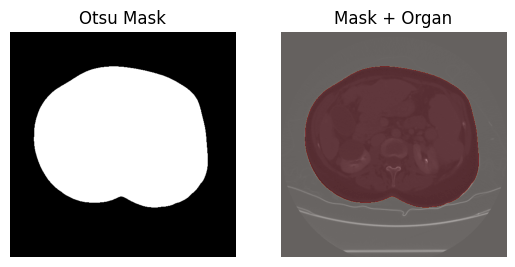

In [ ]:
body_mask = utils.segment_body(ct_volume)
slice_mask = median_axial_plane(body_mask)
plt.subplot(1, 2, 1)
plt.imshow(slice_mask, cmap='gray')
plt.title("Otsu Mask")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(slice_axial, cmap='gray')
plt.imshow(slice_mask, cmap='Reds', alpha=0.4)
plt.title("Mask + Organ")
plt.axis('off')
plt.show()

I used Otsu Threshold to detect the biggest contour of the slices. Here we can see, how the strcuture is removed:

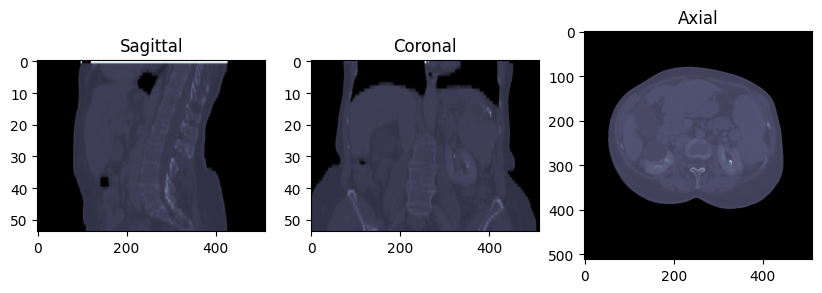

In [ ]:
ct_volume = utils.apply_body_mask(ct_volume, body_mask)
slice_axial = median_axial_plane(ct_volume)
slice_sagittal = median_sagittal_plane(ct_volume)
slice_coronal = median_coronal_plane(ct_volume)
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(slice_sagittal, cmap=cm,vmin = img_min_sag, vmax = img_max_sag, aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Sagittal')
ax[1].imshow(slice_coronal, cmap=cm, vmin = img_min_cor, vmax = img_max_cor,aspect= (pixel_len[2]/pixel_len[1]))
ax[1].set_title('Coronal')
ax[2].imshow(slice_axial, cmap=cm,vmin = img_min_ax, vmax = img_max_ax)
ax[2].set_title('Axial')
plt.show()

The images show really low contrast. We are going to try to enhance the constrast for better visualization

In [ ]:
print(img_min_ax)
print(img_max_ax)

-1024
2111


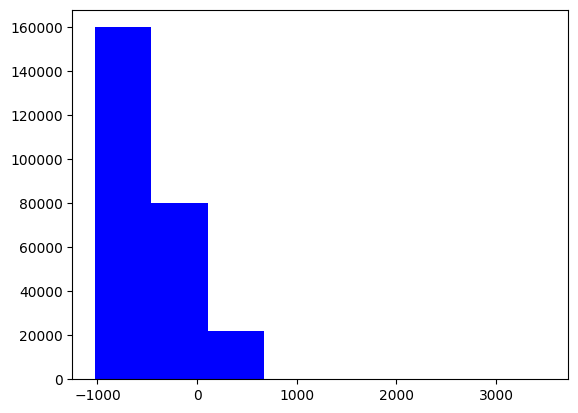

In [ ]:
plt.hist(slice_axial.ravel(), bins=8, range=(-1024, 3500), color='blue')
plt.show()

For better visualization, contrast enhancement using windowing is applied:

In [ ]:
slice_sagittal = utils.apply_windowing(slice_sagittal, 40, 350)
slice_coronal = utils.apply_windowing(slice_coronal, 40, 350)
slice_axial = utils.apply_windowing(slice_axial, 40, 350)

img_min_sag = np.min(slice_sagittal)
img_max_sag = np.max(slice_sagittal)
img_min_cor = np.min(slice_coronal)
img_max_cor = np.max(slice_coronal)
img_min_ax = np.min(slice_axial)
img_max_ax = np.max(slice_axial)

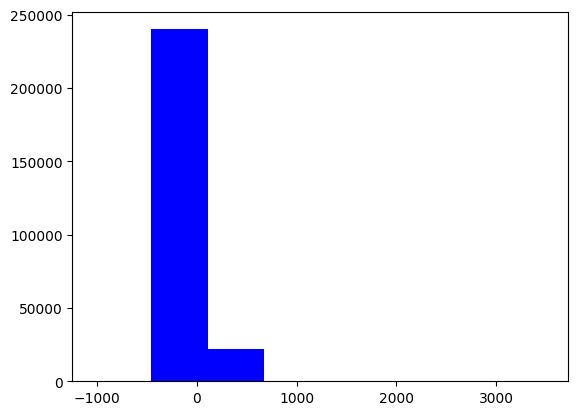

In [ ]:
plt.hist(slice_axial.ravel(), bins=8, range=(-1024, 3500), color='blue')
plt.show()

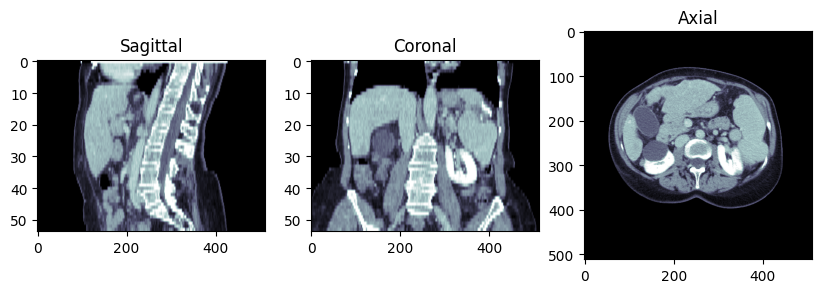

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(slice_sagittal, cmap=cm,vmin = img_min_sag, vmax = img_max_sag, aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Sagittal')
ax[1].imshow(slice_coronal, cmap=cm, vmin = img_min_cor, vmax = img_max_cor,aspect= (pixel_len[2]/pixel_len[1]))
ax[1].set_title('Coronal')
ax[2].imshow(slice_axial, cmap=cm,vmin = img_min_ax, vmax = img_max_ax)
ax[2].set_title('Axial')
plt.show()

We can also compare whether the reconstruction is correct by visualizing the middle axial slice in 3D slicer and the reconstructed volume:

In [15]:
print(slice_locations[ct_volume.shape[0]//2])

-117.000000


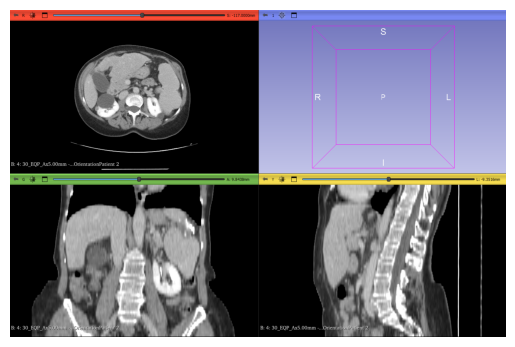

In [16]:
img = cv2.imread("3DSLICER.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

Now, we can visualize the segmentation masks on the images using the painter's algorithm:

In [ ]:

def apply_cmap(img: np.ndarray, cmap_name: str = 'bone', not_label= True) -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    if not_label:
        img = (img - np.min(img)) / (np.ptp(img) + 1e-8)
        img = (img * 255).astype(np.uint8)
    cmap_function = matplotlib.colormaps[cmap_name]
    return cmap_function(img)


def visualize_alpha_fusion(img: np.ndarray, mask: np.ndarray, alpha: float = 0.25, aspect: int = 1):
    """ Visualize both image and mask in the same plot. """
    img_cmapped = apply_cmap(img, cmap_name='bone', not_label=True)
    mask_bone_cmapped = apply_cmap(mask, cmap_name='tab10', not_label= False)

    mask_condition = (mask >= 1)
    
    final_img = img_cmapped.copy()
    final_img[mask_condition] = img_cmapped[mask_condition] * (1-alpha) + np.clip(mask_bone_cmapped[mask_condition] * alpha, a_min=0, a_max=1)
    plt.imshow(final_img, aspect=aspect)
    plt.title(f'Mask with alpha {alpha}')
    plt.show()


def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

In [ ]:
mask_sagittal = median_sagittal_plane(final_segmentation)
mask_coronal = median_coronal_plane(final_segmentation)
mask_axial = median_axial_plane(final_segmentation)

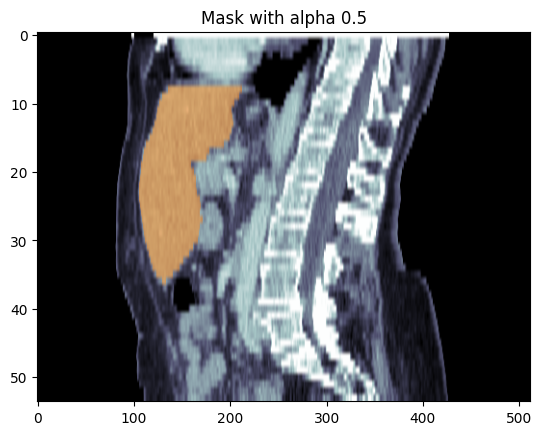

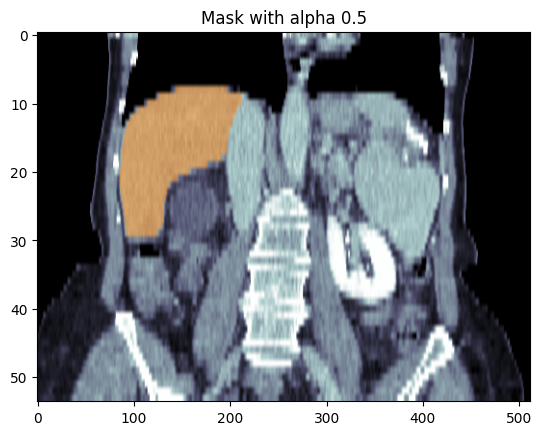

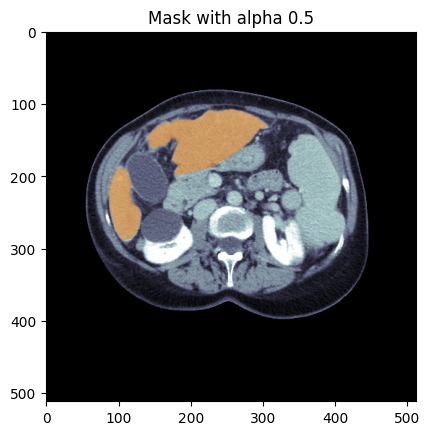

In [ ]:
visualize_alpha_fusion(slice_sagittal, mask_sagittal, 0.5,(pixel_len[2]/pixel_len[0]))
visualize_alpha_fusion(slice_coronal, mask_coronal, 0.5,(pixel_len[2]/pixel_len[1]))
visualize_alpha_fusion(slice_axial, mask_axial, 0.5,1)

We can also compare if the mask is correctly resliced using 3D slicer:

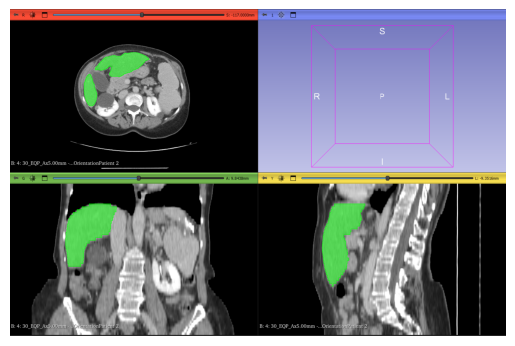

In [17]:
img = cv2.imread("3D_SLICER_mask.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Generation of the MIP projections

In [ ]:
mip_sagittal1 = MIP_sagittal_plane(ct_volume)
mip_coronal1 = MIP_coronal_plane(ct_volume)
mip_axial1 = MIP_axial_plane(ct_volume[1:,:,:])
mip_min_sag1 = np.min(mip_sagittal1)
mip_max_sag1 = np.max(mip_sagittal1)
mip_min_cor1 = np.min(mip_coronal1)
mip_max_cor1 = np.max(mip_coronal1)
mip_min_ax1 = np.min(mip_axial1)
mip_max_ax1 = np.max(mip_axial1)

mip_sagittal = utils.apply_windowing(mip_sagittal1, 450,850)
mip_coronal = utils.apply_windowing(mip_coronal1, 450,850)
mip_axial = utils.apply_windowing(mip_axial1, 450,850)

mip_min_sag = np.min(mip_sagittal)
mip_max_sag = np.max(mip_sagittal)
mip_min_cor = np.min(mip_coronal)
mip_max_cor = np.max(mip_coronal)
mip_min_ax = np.min(mip_axial)
mip_max_ax = np.max(mip_axial)

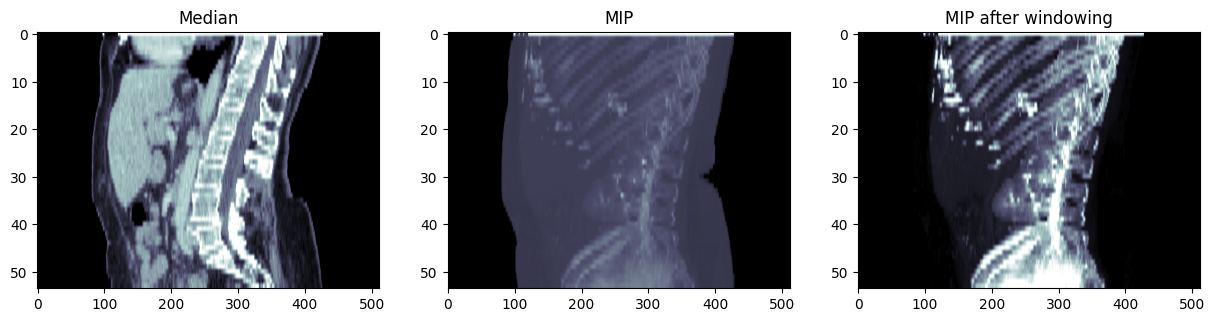

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,15))
ax[0].imshow(slice_sagittal, cmap=cm,vmin = img_min_sag, vmax = img_max_sag,  aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Median')
ax[1].imshow(mip_sagittal1, cmap=cm, vmin = mip_min_sag1, vmax = mip_max_sag1, aspect= (pixel_len[2]/pixel_len[0]))
ax[1].set_title('MIP')
ax[2].imshow(mip_sagittal, cmap=cm, vmin = mip_min_sag, vmax = mip_max_sag, aspect= (pixel_len[2]/pixel_len[0]))
ax[2].set_title('MIP after windowing')
plt.show()

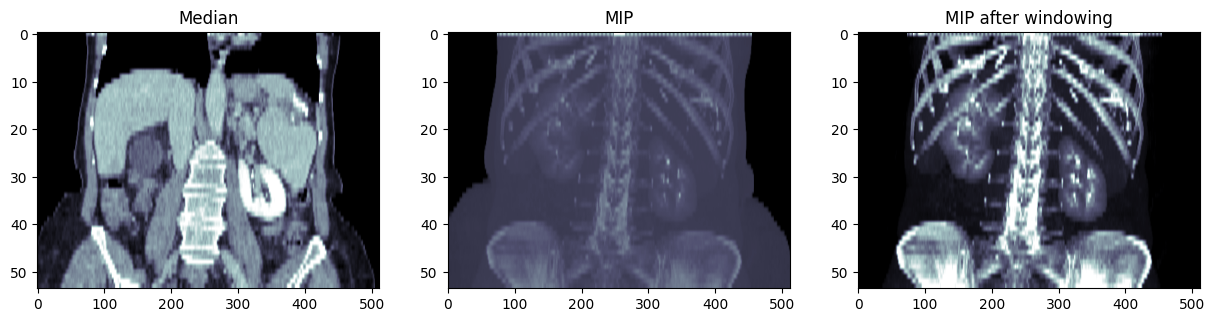

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(slice_coronal,cmap=cm,vmin = img_min_cor, vmax = img_max_cor, aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Median')
ax[1].imshow(mip_coronal1, cmap=cm, vmin = mip_min_cor1, vmax = mip_max_cor1, aspect= (pixel_len[2]/pixel_len[0]))
ax[1].set_title('MIP')
ax[2].imshow(mip_coronal, cmap=cm, vmin = mip_min_cor, vmax = mip_max_cor, aspect= (pixel_len[2]/pixel_len[0]))
ax[2].set_title('MIP after windowing')
plt.show()
plt.show()

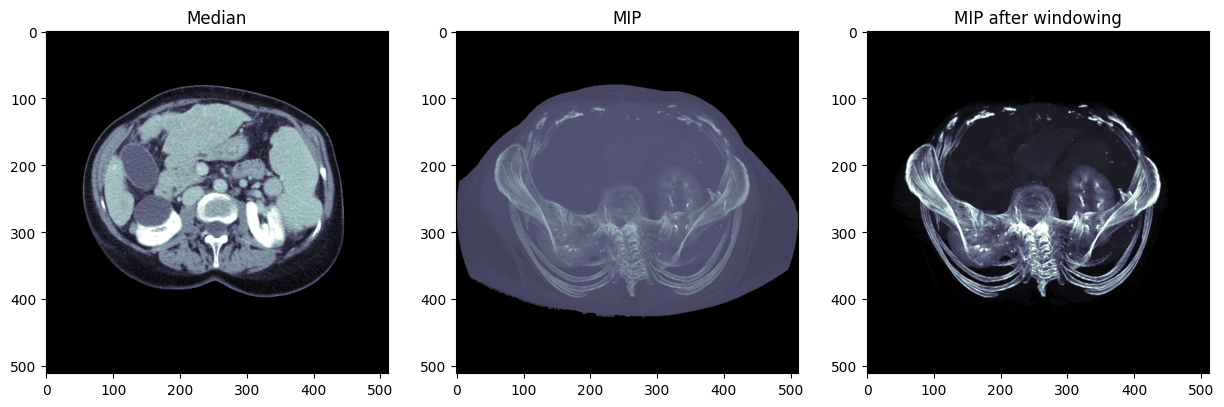

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,15))
ax[0].imshow(slice_axial, cmap=cm,vmin = img_min_ax, vmax = img_max_ax)
ax[0].set_title('Median')
ax[1].imshow(mip_axial1, cmap=cm, vmin = mip_min_ax1, vmax = mip_max_ax1)
ax[1].set_title('MIP')
ax[2].imshow(mip_axial, cmap=cm, vmin = mip_min_ax, vmax = mip_max_ax)
ax[2].set_title('MIP after windowing')
plt.show()

In [ ]:
mip_mask_sagittal = MIP_sagittal_plane(final_segmentation)
mip_mask_coronal = MIP_coronal_plane(final_segmentation)
mip_mask_axial = MIP_axial_plane(final_segmentation[:-1,:,:])

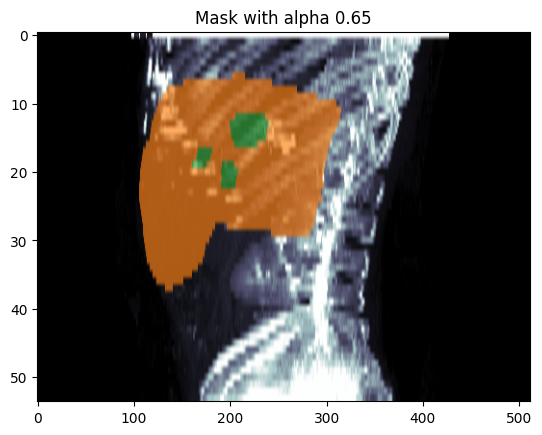

In [ ]:
visualize_alpha_fusion(mip_sagittal,mip_mask_sagittal, 0.65,(pixel_len[2]/pixel_len[0]))

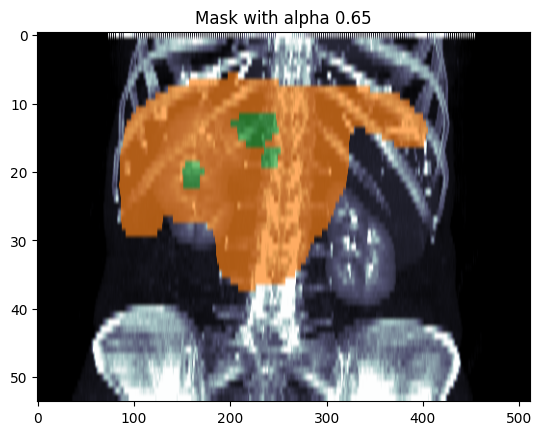

In [ ]:
visualize_alpha_fusion(mip_coronal, mip_mask_coronal, 0.65,(pixel_len[2]/pixel_len[0]))

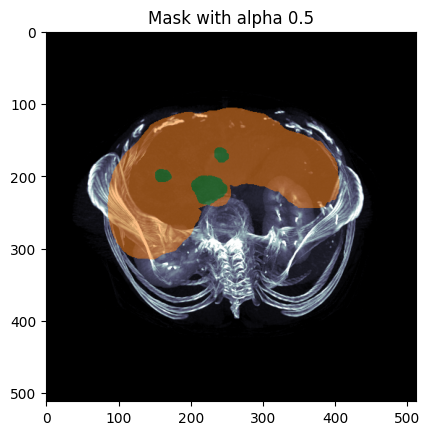

In [ ]:
visualize_alpha_fusion(mip_axial, mip_mask_axial, 0.5,1)

In [ ]:
def save_animation(projections, min, max,name):
    animation_data = []
    fig, ax = plt.subplots()
    for img in projections: 
        img = ax.imshow(img, animated=True, cmap=cm, vmin=min, vmax=max, aspect=(pixel_len[2]/pixel_len[1]))
        animation_data.append([img])
    anim = animation.ArtistAnimation(fig, animation_data,
                                interval=250, blit=True)
    anim.save(f'results/MIP/{name}/Animation.gif')  # Save animation
    plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


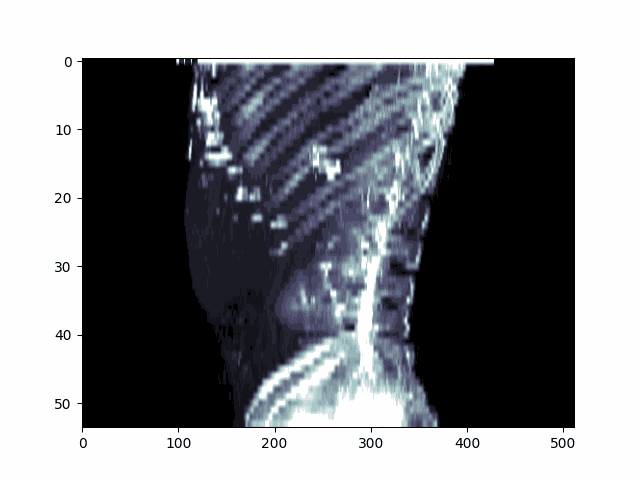

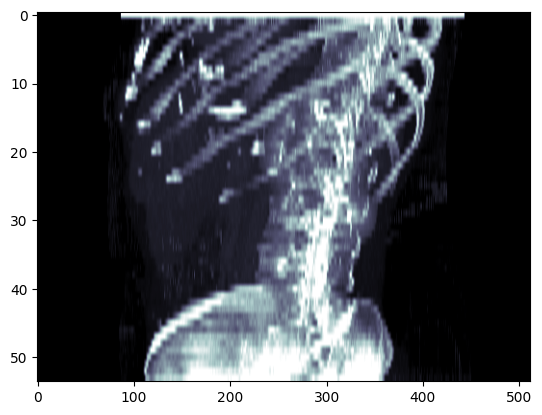

In [ ]:
fig, ax = plt.subplots()
n = 16
projections1 = []

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    projection = utils.apply_windowing(projection, 450,850)
    mip_min_sag = np.min(projection)
    mip_max_sag = np.max(projection)
    plt.imshow(projection, cmap=cm, vmin=mip_min_sag, vmax=mip_max_sag, aspect=(pixel_len[2]/pixel_len[0]))
    plt.savefig(f'results/MIP/Sagittal/Projection_{idx}.png')      
    projections1.append(projection)  
save_animation(projections1, mip_min_sag, mip_max_sag,'Sagittal')
Image(filename='results/MIP/Sagittal/Animation.gif')
  

MovieWriter ffmpeg unavailable; using Pillow instead.


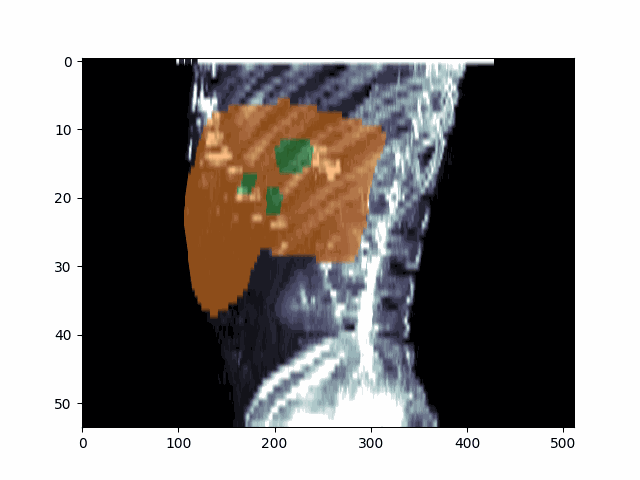

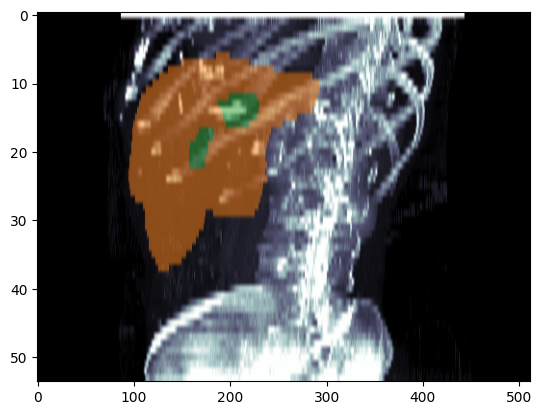

In [ ]:
fig, ax = plt.subplots()
n = 16
projections_alpha = []

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    rotated_mask = rotate_on_axial_plane(final_segmentation, alpha)


    projection = MIP_sagittal_plane(rotated_img)
    projection = utils.apply_windowing(projection, 450,850)
    mip_min_sag = np.min(projection)
    mip_max_sag = np.max(projection)

    mask_projection = MIP_sagittal_plane(rotated_mask)
    mask_projection= np.clip(mask_projection, 0, 2) 

    img_cmapped = apply_cmap(projection, cmap_name='bone', not_label=True)
    mask_bone_cmapped = apply_cmap(mask_projection, cmap_name='tab10',  not_label=False)
    mask_condition = (mask_projection >=1)
    
    final_img = img_cmapped.copy()
    final_img[mask_condition] = img_cmapped[mask_condition] * (1-0.5) + mask_bone_cmapped[mask_condition] * 0.5
    plt.imshow(final_img, aspect=(pixel_len[2]/pixel_len[0]))
    plt.savefig(f'results/MIP/Alpha_Sagittal/Projection_{idx}.png')     
     
    projections_alpha.append(final_img)  
save_animation(projections_alpha, mip_min_sag, mip_max_sag,'Alpha_Sagittal')
Image(filename='results/MIP/Alpha_Sagittal/Animation.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


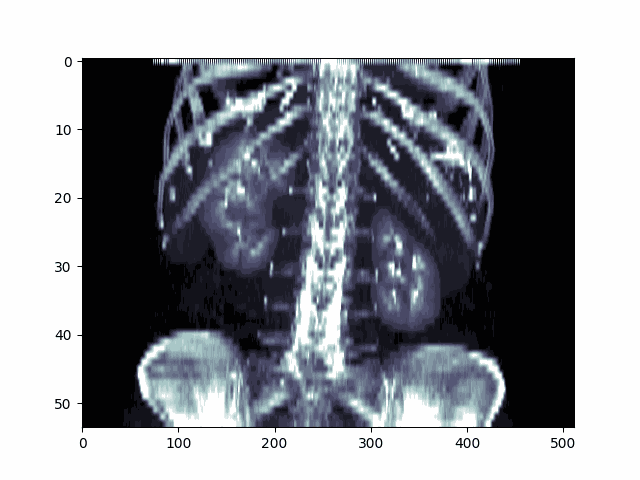

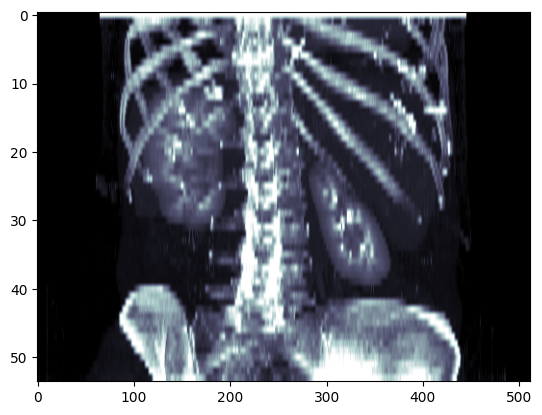

In [ ]:
fig, ax = plt.subplots()
projections2 = []
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    projection = MIP_coronal_plane(rotated_img)
    projection = utils.apply_windowing(projection, 450,850)
    mip_min_cor = np.min(projection)
    mip_max_cor = np.max(projection)
    plt.imshow(projection, cmap=cm, vmin=mip_min_cor, vmax=mip_max_cor, aspect=(pixel_len[2]/pixel_len[1]))
    plt.savefig(f'results/MIP/Coronal/Projection_{idx}.png')      
    projections2.append(projection) 
save_animation(projections2, mip_min_cor, mip_max_cor, 'Coronal')
Image(filename='results/MIP/Coronal/Animation.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


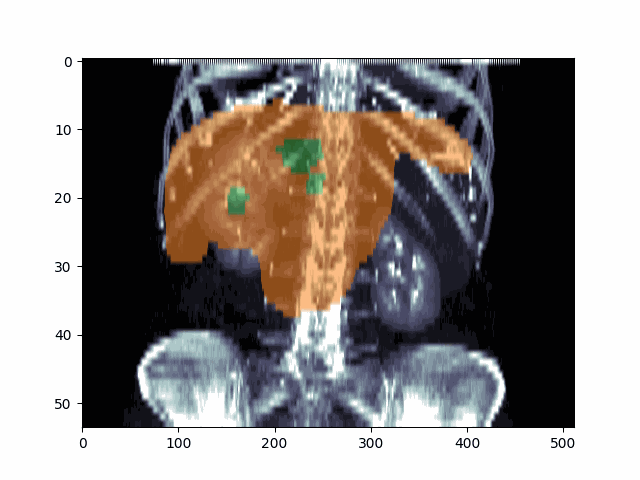

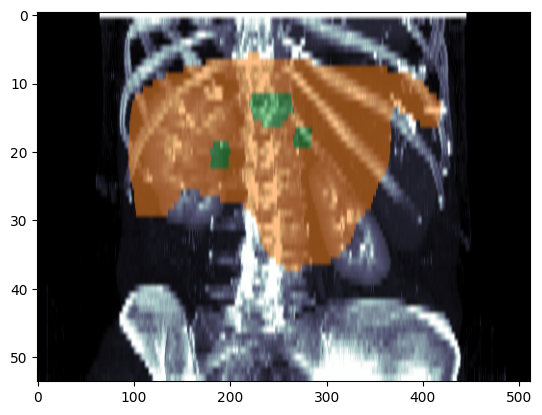

In [ ]:
fig, ax = plt.subplots()
n = 16
projections_alpha = []

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    rotated_mask = rotate_on_axial_plane(final_segmentation, alpha)


    projection = MIP_coronal_plane(rotated_img)
    projection = utils.apply_windowing(projection, 450,850)
    mip_min_cor = np.min(projection)
    mip_max_cor = np.max(projection)

    mask_projection = MIP_coronal_plane(rotated_mask)
    img_cmapped = apply_cmap(projection, cmap_name='bone', not_label=True)
    mask_bone_cmapped = apply_cmap(mask_projection, cmap_name='tab10',  not_label=False)
    mask_condition = (mask_projection >=1)
    
    final_img = img_cmapped.copy()
    final_img[ mask_condition] = img_cmapped[mask_condition] * (1-0.5) + mask_bone_cmapped[mask_condition] * 0.5
    plt.imshow(final_img, aspect=(pixel_len[2]/pixel_len[1]))
    plt.savefig(f'results/MIP/Alpha_Coronal/Projection_{idx}.png')     
    projections_alpha.append(final_img)  

save_animation(projections_alpha, mip_min_cor, mip_max_cor,'Alpha_Coronal')
Image(filename='results/MIP/Alpha_Coronal/Animation.gif')